# Episode 05 - Under the hood - Graphs

TODO intro / goals / TOC

TODO presentation graphs and networkx

https://networkx.org/documentation/stable/tutorial.html

TODO colorisation problem

# 1. Graph exemple 

In [ ]:
! pip install networkx

In [25]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
G = nx.petersen_graph()

subax1 = plt.subplot(121)

nx.draw(G, with_labels=True, font_weight='bold')

In [ ]:
G.number_of_nodes()

In [ ]:
G.number_of_edges()

In [ ]:
list(G.nodes)

In [ ]:
list(G.edges)

In [ ]:
list(G.degree())

In [ ]:
list(nx.connected_components(G))

In [ ]:
nx.clustering(G)

examine nodes and edges

In [ ]:
G[1] 

In [ ]:
G.nodes[1] # exists and does not have any attribute

In [ ]:
list(G.adj[1])  # or list(G.neighbors(1))

In [ ]:
G.degree[1]  # the number of edges incident to 1

In [ ]:
G.edges[1, 2]  # or G[1][2] 

build graph

In [ ]:
G.add_nodes_from(["A", "B", "C"]) 
G.add_edges_from([["A", "B"], ["B", "C"]]) 

In [ ]:
nx.draw(G, with_labels=True, font_weight='bold')

In [ ]:
nx.clustering(G)

In [ ]:
list(nx.connected_components(G))

In [ ]:
list(G.degree())

attributes

In [ ]:
for node in range(0,9,2):
    G.nodes[node]['parity'] = "even"

In [ ]:
for node in range(1,10,2):
    G.nodes[node]['parity'] = "odd"

In [ ]:
G.nodes[1]

In [ ]:
list(G.nodes(data=True))

In [ ]:
G.edges["A", "B"]['role'] = "next"
G.edges["B", "C"]['role'] = "next"

In [ ]:
G.edges["A", "B"]

In [ ]:
list(G.edges(data=True))

In [ ]:
G.remove_nodes_from(["A", "B", "C"])

In [ ]:
list(G.nodes)

In [ ]:
list(G.edges)

search

In [ ]:
SG=G.subgraph([id for id,attr in G.nodes(data=True) if "parity" in attr and attr['parity']=="even"])

In [ ]:
list(SG.nodes(data=True))

# 2. Experiment with 2x2 puzzle

main idea
- graph all hypothesis for solving the board
- clue -> n options -> each option has groups of cells alternating black anf filler -> cells belong to one or more of these groups
- if cell belong to only one group it can be tell black or filler with 100% chance
- when a black belongs to a filler group the option it belongs to can be cancelled
- over iterations the number of options reduces and other cells can be placed

asummes there is one solution

## 2.1. Board representation

As in other experiments choice must be made to represent cells by their position on 1D array or by coordinates in a 2D array

**node name**
- As there is no notion of array here, using labels like r1c1 will help debugging. Cells will be linked horizontally and vertically
- a prefix B| will be added at the stard of the name to get a visual clue of the role

**attributes for nodes**
- row and col:  this will help to verify the graph consistency, layer the nodes for visual representation and add edges later if need be
- state : represented by BoardMark values
- role : being board

**attributes for edges**
- role : being board
- orientation : having two values vrt or hrz


In [ ]:
from episode04 import BoardMark
from enum import Enum

In [ ]:
class Roles(Enum):
    BOARD = 0
    
class Orientation(Enum):
    ROW = 0
    COL = 1

In [10]:
def build_board(tmpG):
    # board nodes
    for r in range(2):
        for c in range(2):
            name = f"B|r{r}c{c}" 
            tmpG.add_node(name, role=Roles.BOARD, row=r, col=c, state=BoardMark.INIT.value)

    # board edges for rows
    for r in range(2):
        n1 = f"B|r{r}c0" 
        n2 = f"B|r{r}c1" 
        tmpG.add_edge(n1, n2, role=Roles.BOARD, row=r, orientation=Orientation.ROW)

    for c in range(2):
        n1 = f"B|r0c{c}" 
        n2 = f"B|r1c{c}" 
        tmpG.add_edge(n1, n2, role=Roles.BOARD, col=c, orientation=Orientation.COL)

    return tmpG

In [ ]:
boardG = nx.Graph()
boardG = build_board(boardG)

In [ ]:
list(boardG.nodes(data=True))

In [ ]:
list(boardG.edges(data=True))

In [ ]:
pos = nx.spring_layout(boardG, seed=3113794652)
pos

In [24]:
def display_board(a_board):
    mpl.rcParams['figure.figsize'] = 10, 5 #w,h
    subax1 = plt.subplot(121)
    
    pos = {
        'B|r0c0': [0., 0],
        'B|r0c1': [1, 0],
        'B|r1c0': [0., -1],
        'B|r1c1': [1, -1]
    }
    # x=col y= row - col in reverse order
    
    options = {
        'with_labels': True, 
        'node_size': 2000, 
        'font_color': 'white', 
        'font_weight': 'bold'
    } 
    board_colors = {
        BoardMark.INIT.value: 'violet',
        BoardMark.FILLER.value: 'lavender',
        BoardMark.BLACK.value: 'indigo'
    }
    colors = [board_colors[data['state']] for v, data in a_board.nodes(data=True)]

    nx.draw(a_board, pos, node_color=colors, **options)

In [ ]:
display_board(boardG)

In [ ]:
updatedBoardG = boardG.copy()
updatedBoardG.nodes['B|r1c0']['state'] = BoardMark.BLACK.value
updatedBoardG.nodes['B|r0c1']['state'] = BoardMark.FILLER.value
display_board(updatedBoardG)

## 2.2. Puzzle representation

**node name**
- like r1 or c1 
- a prefix P| will be added at the stard of the name to get a visual clue of the role

**attributes for nodes**
- the clue value (only a number for the scope of the experiment)
- row or col:  this will help to verify the graph consistency, layer the node for visual representation and add edges later if need be
- role : being puzzle
- orientation : having two values vrt or hrz for consistency with board

No edges between puzzle clues neither direct edge with board cells. Pathes between puzzle clues and board cells will be created by the solver.

In [ ]:
from episode04 import BoardMark
from enum import Enum

class Roles(Enum):
    PUZZLE = 0
    BOARD = 1
    
class Orientation(Enum):
    ROW = 0
    COL = 1

In [11]:
def build_puzzle(tmpG):
    # clue nodes
    for r in range(2):
        name = f"P|r{r}" 
        tmpG.add_node(name, role=Roles.PUZZLE, row=r, orientation=Orientation.ROW)
    tmpG.nodes["P|r0"]['clue'] = 1
    tmpG.nodes["P|r1"]['clue'] = 2

    for c in range(2):
        name = f"P|c{c}" 
        tmpG.add_node(name, role=Roles.PUZZLE, col=c, orientation=Orientation.COL)
    tmpG.nodes["P|c0"]['clue'] = 2
    tmpG.nodes["P|c1"]['clue'] = 1

    return tmpG

In [ ]:
puzzleG = nx.Graph()
puzzleG = build_puzzle(puzzleG)

In [ ]:
list(puzzleG.nodes)

In [ ]:
list(puzzleG.nodes(data='orientation'))

## 2.3. Solver Hypothesis

the solver will add two types of nodes: Hypothesis and Group

An hypothesis is created for each way of filling a row or col. For instance, there are tow way of holting the clue for row 1 (sum is 1 over a row of 2 cells) :
- [0,1] first cell is a filler and second is a black
- [1,0] first cell is a black and second is a filler

Two hypothesis will be attached to the row 1, r1A and r1B. 
Each hypothesis consists of two groups holding the continuous blocks.

First hypothesis r1A:
- r1A group 0 is a block of 1 filler mapped to r1c0
- r1A group 1 is a block of 1 black mapped to r1c1

Similarly, second hypothesis r1B:
- r1B group 0 is a block of 1 black mapped to r1c0
- r1B group 1 is a block of 1 filler mapped to r1c1

Edges are created between clues and hypothesis, hypothesis and groups, groups and cells.

**hypothesis node name**
- built from the clue name like r1A r1B
- a prefix H| will be added at the stard of the name

**attributes for hypothesis nodes**
- row or col:  this will help to verify the graph consistency
- role : being hypothesis

**group node name**
- built from the hypothesis name like r1A1 r1A2
- a prefix G| will be added at the stard of the name

**attributes for group nodes**
- row or col:  this will help to verify the graph consistency
- state : represented by BoardMark values
- role : being group

**attributes for edges**
- role : being hypothesis


In [6]:
import networkx as nx
import matplotlib.pyplot as plt

In [7]:
from episode04 import BoardMark
from enum import Enum

class Roles(Enum):
    PUZZLE = 0
    HYPOTHESIS = 1
    GROUP = 2
    BOARD = 3
    
class Orientation(Enum):
    ROW = 0
    COL = 1

In [8]:
def build_solver_2_over_2(tmpG, prefix, orientation, index, cells):
    p_name = f"P|{prefix}"
    h_name = f"H|{prefix}A"
    g_name = f"G|{prefix}A1"
    tmpG.add_edges_from([(p_name, h_name),
                         (h_name, g_name)], role = Roles.HYPOTHESIS)
    for cell in cells:
        tmpG.add_edge(g_name, cell, role = Roles.HYPOTHESIS)

    tmpG.nodes[h_name]['role'] = Roles.HYPOTHESIS
    tmpG.nodes[h_name][orientation] = index
    tmpG.nodes[g_name]['role'] = Roles.GROUP
    tmpG.nodes[g_name][orientation] = index
    tmpG.nodes[g_name]['state'] = BoardMark.BLACK.value

    return tmpG
        
def build_solver_1_over_2(tmpG, prefix, orientation, index, cells):
    p_name = f"P|{prefix}"
    for h in ['A', 'B']:
        h_name = f"H|{prefix}{h}"
        tmpG.add_edge(p_name, h_name, role = Roles.HYPOTHESIS)
        for g,cell in enumerate(cells):
            g_name = f"G|{prefix}{h}{g}"
            tmpG.add_edge(h_name, g_name, role = Roles.HYPOTHESIS)
            G.add_edge(g_name, cell, role = Roles.HYPOTHESIS)
            tmpG.nodes[g_name]['role'] = Roles.GROUP
            tmpG.nodes[g_name][orientation] = index
        tmpG.nodes[h_name]['role'] = Roles.HYPOTHESIS
        tmpG.nodes[h_name][orientation] = index
    tmpG.nodes[f"G|{prefix}A0"]['state'] = BoardMark.FILLER.value
    tmpG.nodes[f"G|{prefix}A1"]['state'] = BoardMark.BLACK.value
    tmpG.nodes[f"G|{prefix}B0"]['state'] = BoardMark.BLACK.value
    tmpG.nodes[f"G|{prefix}B1"]['state'] = BoardMark.FILLER.value

    return tmpG

In [12]:
G = nx.Graph()
G = build_board(G)
G = build_puzzle(G)
G = build_solver_1_over_2(G, 'r0', 'row', 1, ["B|r0c0", "B|r0c1"])
G = build_solver_2_over_2(G, 'r1', 'row', 1, ["B|r1c0", "B|r1c1"])
G = build_solver_2_over_2(G, 'c0', 'col', 0, ["B|r0c0", "B|r1c0"])
G = build_solver_1_over_2(G, 'c1', 'col', 1, ["B|r0c1", "B|r1c1"])


In [13]:
list(sorted(G.nodes))

['B|r0c0',
 'B|r0c1',
 'B|r1c0',
 'B|r1c1',
 'G|c0A1',
 'G|c1A0',
 'G|c1A1',
 'G|c1B0',
 'G|c1B1',
 'G|r0A0',
 'G|r0A1',
 'G|r0B0',
 'G|r0B1',
 'G|r1A1',
 'H|c0A',
 'H|c1A',
 'H|c1B',
 'H|r0A',
 'H|r0B',
 'H|r1A',
 'P|c0',
 'P|c1',
 'P|r0',
 'P|r1']

In [14]:
list(sorted(G.nodes(data=True)))

[('B|r0c0', {'role': <Roles.BOARD: 3>, 'row': 0, 'col': 0, 'state': -1}),
 ('B|r0c1', {'role': <Roles.BOARD: 3>, 'row': 0, 'col': 1, 'state': -1}),
 ('B|r1c0', {'role': <Roles.BOARD: 3>, 'row': 1, 'col': 0, 'state': -1}),
 ('B|r1c1', {'role': <Roles.BOARD: 3>, 'row': 1, 'col': 1, 'state': -1}),
 ('G|c0A1', {'role': <Roles.GROUP: 2>, 'col': 0, 'state': 1}),
 ('G|c1A0', {'role': <Roles.GROUP: 2>, 'col': 1, 'state': 0}),
 ('G|c1A1', {'role': <Roles.GROUP: 2>, 'col': 1, 'state': 1}),
 ('G|c1B0', {'role': <Roles.GROUP: 2>, 'col': 1, 'state': 1}),
 ('G|c1B1', {'role': <Roles.GROUP: 2>, 'col': 1, 'state': 0}),
 ('G|r0A0', {'role': <Roles.GROUP: 2>, 'row': 1, 'state': 0}),
 ('G|r0A1', {'role': <Roles.GROUP: 2>, 'row': 1, 'state': 1}),
 ('G|r0B0', {'role': <Roles.GROUP: 2>, 'row': 1, 'state': 1}),
 ('G|r0B1', {'role': <Roles.GROUP: 2>, 'row': 1, 'state': 0}),
 ('G|r1A1', {'role': <Roles.GROUP: 2>, 'row': 1, 'state': 1}),
 ('H|c0A', {'role': <Roles.HYPOTHESIS: 1>, 'col': 0}),
 ('H|c1A', {'role':

In [15]:
list(sorted(G.nodes(data='role')))

[('B|r0c0', <Roles.BOARD: 3>),
 ('B|r0c1', <Roles.BOARD: 3>),
 ('B|r1c0', <Roles.BOARD: 3>),
 ('B|r1c1', <Roles.BOARD: 3>),
 ('G|c0A1', <Roles.GROUP: 2>),
 ('G|c1A0', <Roles.GROUP: 2>),
 ('G|c1A1', <Roles.GROUP: 2>),
 ('G|c1B0', <Roles.GROUP: 2>),
 ('G|c1B1', <Roles.GROUP: 2>),
 ('G|r0A0', <Roles.GROUP: 2>),
 ('G|r0A1', <Roles.GROUP: 2>),
 ('G|r0B0', <Roles.GROUP: 2>),
 ('G|r0B1', <Roles.GROUP: 2>),
 ('G|r1A1', <Roles.GROUP: 2>),
 ('H|c0A', <Roles.HYPOTHESIS: 1>),
 ('H|c1A', <Roles.HYPOTHESIS: 1>),
 ('H|c1B', <Roles.HYPOTHESIS: 1>),
 ('H|r0A', <Roles.HYPOTHESIS: 1>),
 ('H|r0B', <Roles.HYPOTHESIS: 1>),
 ('H|r1A', <Roles.HYPOTHESIS: 1>),
 ('P|c0', <Roles.PUZZLE: 0>),
 ('P|c1', <Roles.PUZZLE: 0>),
 ('P|r0', <Roles.PUZZLE: 0>),
 ('P|r1', <Roles.PUZZLE: 0>)]

## 2.4. Solver Display

In [16]:
# make a copy before experimenting
expeG = G.copy()

In [17]:
def layering(a_graph):
    # add a layer attribute
    # some displays use layers (multipartite_layout, shell_layout)
    # layers are derived from role
    # multipartite_layout required the layer is an attribute and is a number    
    for name, role in a_graph.nodes(data='role'):
        a_graph.nodes[name]['layer'] = role.value

In [ ]:
layering(expeG)
list(sorted(expeG.nodes(data='layer')))

In [ ]:
def display_tests(a_graph, pos):
    mpl.rcParams['figure.figsize'] = 20, 15 #w,h
    subax1 = plt.subplot(121)

    options = {
        'with_labels': True, 
        'node_size': 2000, 
        'font_color': 'white', 
        'font_weight': 'bold'
    } 
    subset_color = [
        "darkorange", # clue 
        "limegreen", # hypothesis
        "lightblue", # group
        "violet", # board
    ]
    colors = [subset_color[data["layer"]] for v, data in a_graph.nodes(data=True)]
    width_f = lambda attr: 3 if 'role' in attr and attr['role'] == Roles.BOARD else 0.5
    edge_width = [width_f(data) for name1, name2, data in a_graph.edges(data=True)]

    nx.draw(a_graph, pos, width=edge_width, node_color=colors, **options)

In [ ]:
# spring (default)
pos = nx.spring_layout(expeG)
display_tests(expeG, pos)

In [ ]:
# spectral
pos = nx.spectral_layout(expeG)
display_tests(expeG, pos)

In [ ]:
# circular
pos = nx.circular_layout(expeG)
display_tests(expeG, pos)

In [ ]:
# planar -> not planar
#pos = nx.planar_layout(expeG)
#display_tests(expeG, pos)

In [ ]:
pos = nx.kamada_kawai_layout(expeG, scale=100)
display_tests(expeG, pos)

In [ ]:
pos = nx.multipartite_layout(expeG, subset_key="layer")
display_tests(expeG, pos)

In [ ]:
shells = [[], [], [], []]
for name,layer in expeG.nodes(data='layer'):
    shells[layer].append(name)
shells.reverse()
pos = nx.shell_layout(expeG, shells)
display_tests(expeG, pos)

kamada kawai and multipartite are effective

In [ ]:
boardG = expeG.subgraph([name for name,role in expeG.nodes(data='role')
                         if role == Roles.BOARD])
list(boardG)

In [ ]:
boardG.nodes['B|r1c0']['state'] = BoardMark.BLACK.value
boardG.nodes['B|r0c1']['state'] = BoardMark.FILLER.value

In [ ]:
display_board(boardG)

would like to have the same state on display 

BOARD -> 3 colors depending on state violet, lavender, indigo
GROUP -> lightblue blue depending on state
HYPOTHESIS and PUZZLE -> change color when sole option

In [18]:
# color names https://en.wikipedia.org/wiki/X11_color_names
def colorization(a_graph):
    # ass a color attribute
    subset_color = [
        "gold", # clue 
        "darkorange", # clue has unique hypothesis
        "limegreen", # hypothesis
        "forestgreen", # hypothesis is unique
        "lightblue", # group filler
        "darkcyan", # group black
        "violet", # board undefined
        "lavender", # board filler
        "indigo", # board balck
    ]

    for name, data in a_graph.nodes(data=True):
        # base_color is twice the layer
        base_color = data['layer'] * 2
        color = base_color
        role = data['role']
        if role == Roles.BOARD:
            state = data['state']
            color = base_color + 1 + state # range of values is -1,0,1
        elif role == Roles.GROUP:
            state = data['state']
            color = base_color + state # range of values is 0,1
        elif role == Roles.PUZZLE:
            degree = a_graph.degree(name)
            if degree == 1: # clue -> hypothesis 
                color = base_color + 1
        elif role == Roles.HYPOTHESIS:
            for n_name in a_graph.neighbors(name):
                if a_graph.nodes[n_name]['role'] == Roles.PUZZLE:
                    if a_graph.degree(n_name) == 1:
                        color = base_color + 1
        
        #print(f"name:{name} -> color:{color}")
        if color < len(subset_color):
            a_graph.nodes[name]['color'] = subset_color[color]
        else:
            a_graph.nodes[name]['color'] = 'gray'


In [ ]:
colorization(expeG)

In [ ]:
list(expeG.nodes(data='color'))

In [ ]:
list(nx.get_node_attributes(expeG, "color").values())

In [38]:
def display_generic(a_graph, pos, figsize=(20, 15)):
    colorization(expeG)
    
    mpl.rcParams['figure.figsize'] = figsize #w,h
    subax1 = plt.subplot(121)

    options = {
        'with_labels': True, 
        'node_size': 2000, 
        'font_color': 'white', 
        'font_weight': 'bold'
    } 
    colors = list(nx.get_node_attributes(a_graph, "color").values())
    width_f = lambda attr: 3 if 'role' in attr and attr['role'] == Roles.BOARD else 0.5
    edge_width = [width_f(data) for name1, name2, data in a_graph.edges(data=True)]

    nx.draw(a_graph, pos, width=edge_width, node_color=colors, **options)

def display_layers(a_graph):
    layering(a_graph)
    pos = nx.multipartite_layout(a_graph, subset_key="layer")
    display_generic(a_graph, pos)

def display_kamada_kawai(a_graph):
    layering(a_graph) # required for colorization
    pos = nx.kamada_kawai_layout(expeG)
    display_generic(a_graph, pos)
    
def display_board(a_graph):
    layering(a_graph) # required for colorization
    boardG = a_graph.subgraph([name for name,role in a_graph.nodes(data='role')
                         if role == Roles.BOARD])
    
    pos = {
        'B|r0c0': [0., 0],
        'B|r0c1': [1, 0],
        'B|r1c0': [0., -1],
        'B|r1c1': [1, -1]
    }
    # x=col y= row - col in reverse order
    display_generic(boardG, pos, figsize=(10, 5))

In [ ]:
display_board(expeG)

In [ ]:
display_kamada_kawai(expeG)

In [ ]:
display_layers(expeG)

# 2.5. Solver processing

In [19]:
# make a copy before experimenting
expeG = G.copy()

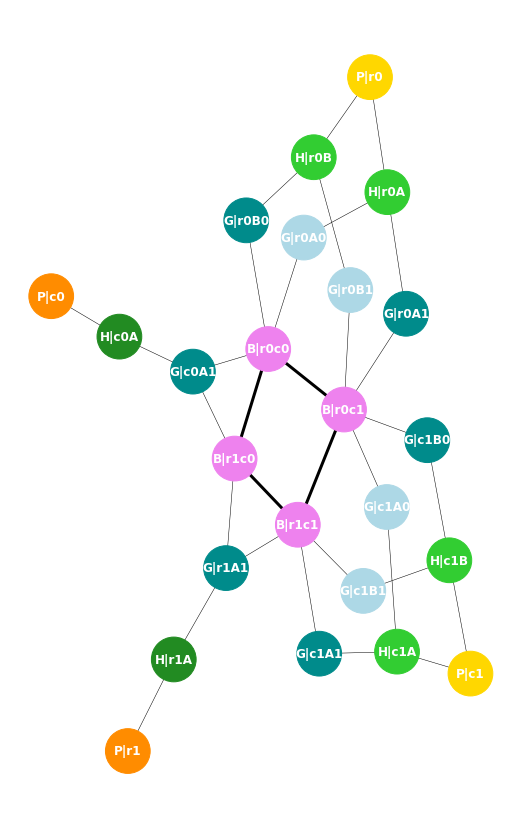

In [26]:
display_kamada_kawai(expeG)

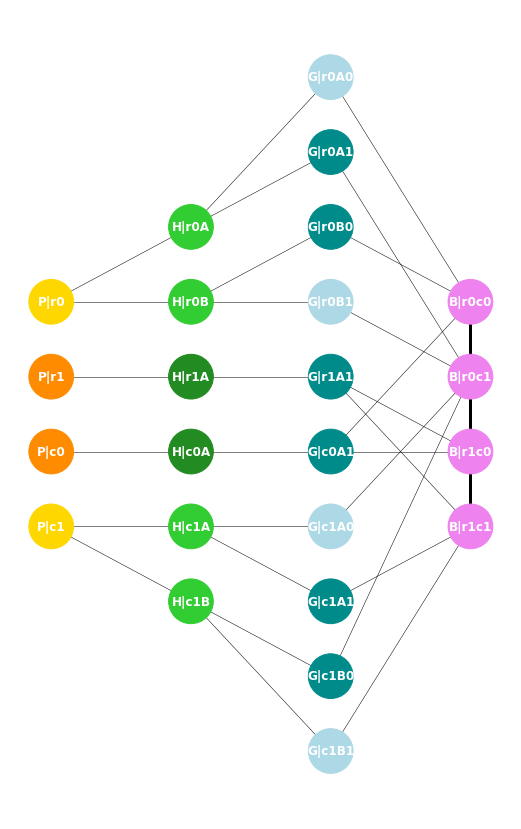

In [27]:
display_layers(expeG)

In [28]:
clues = [name for name, role in expeG.nodes(data='role') if role == Roles.PUZZLE]
hyps = [name for name, role in expeG.nodes(data='role') if role == Roles.HYPOTHESIS]
groups = [name for name, role in expeG.nodes(data='role') if role == Roles.GROUP]
board = [name for name, role in expeG.nodes(data='role') if role == Roles.BOARD]


In [29]:
# filter single option 
for source in clues:
    print(list(nx.all_simple_paths(expeG, source, hyps, cutoff=1)))

[['P|r0', 'H|r0B'], ['P|r0', 'H|r0A']]
[['P|r1', 'H|r1A']]
[['P|c0', 'H|c0A']]
[['P|c1', 'H|c1B'], ['P|c1', 'H|c1A']]


In [30]:
def lookup_single_hypothesis(a_graph):
    clues = [name for name, role in a_graph.nodes(data='role') if role == Roles.PUZZLE]
    hyps = [name for name, role in a_graph.nodes(data='role') if role == Roles.HYPOTHESIS]
    single_hypothesis = []
    for source in clues:
        paths = list(nx.all_simple_paths(a_graph, source, hyps, cutoff=1))
        if len(paths) == 1:
            single_hypothesis .append(paths[0][1])

    return single_hypothesis

In [32]:
single_hypothesis = lookup_single_hypothesis(expeG)
single_hypothesis

['H|r1A', 'H|c0A']

In [34]:
# updatable states
groups = [name for name, role in expeG.nodes(data='role') if role == Roles.GROUP]
for hyp in single_hypothesis:
    group_paths = list(nx.all_simple_paths(expeG, hyp, groups, cutoff=1))
    print(group_paths)
    # want to propagate group state to group's cells  
    for group_path in group_paths:
        group_name = group_path[1]
        cells_paths = list(nx.all_simple_paths(expeG, group_name, board, cutoff=1))
        print(cells_paths)
        for cell_path in cells_paths:
            cell_name = cell_path[1]
            print(f"group_name:{group_name} -> cell_name:{cell_name}")


[['H|r1A', 'G|r1A1']]
[['G|r1A1', 'B|r1c1'], ['G|r1A1', 'B|r1c0']]
group_name:G|r1A1 -> cell_name:B|r1c1
group_name:G|r1A1 -> cell_name:B|r1c0
[['H|c0A', 'G|c0A1']]
[['G|c0A1', 'B|r0c0'], ['G|c0A1', 'B|r1c0']]
group_name:G|c0A1 -> cell_name:B|r0c0
group_name:G|c0A1 -> cell_name:B|r1c0


In [35]:
def apply_single_hypothesis(a_graph, some_single_hypothesis):
    board = [name for name, role in a_graph.nodes(data='role') if role == Roles.BOARD]
    groups = [name for name, role in a_graph.nodes(data='role') if role == Roles.GROUP]
    for hyp in some_single_hypothesis:
        group_paths = list(nx.all_simple_paths(a_graph, hyp, groups, cutoff=1))
        #print(group_paths)
        # propagate group state to group's cells  
        for group_path in group_paths:
            group_name = group_path[1]
            cells_paths = list(nx.all_simple_paths(a_graph, group_name, board, cutoff=1))
            #print(cells_paths)
            for cell_path in cells_paths:
                cell_name = cell_path[1]
                print(f"group_name:{group_name} -> cell_name:{cell_name}")
                a_graph.nodes[cell_name]['state'] = a_graph.nodes[group_name]['state']


In [36]:
apply_single_hypothesis(expeG, single_hypothesis)

group_name:G|r1A1 -> cell_name:B|r1c1
group_name:G|r1A1 -> cell_name:B|r1c0
group_name:G|c0A1 -> cell_name:B|r0c0
group_name:G|c0A1 -> cell_name:B|r1c0


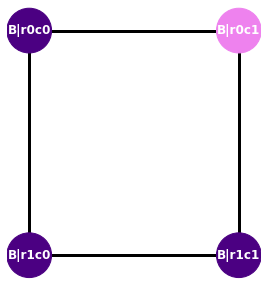

In [39]:
display_board(expeG)

In [42]:
# can remove single hypothesis
# and all adjacents (groups and clues)
def remove_single_hypothesis(a_graph, some_single_hypothesis):
    adjacents = []
    for hyp_name in some_single_hypothesis:
        for adj_name in a_graph.neighbors(hyp_name):
            adjacents.append(adj_name)

    a_graph.remove_nodes_from(adjacents)   
    a_graph.remove_nodes_from(single_hypothesis)   

In [43]:
remove_single_hypothesis(expeG, single_hypothesis)

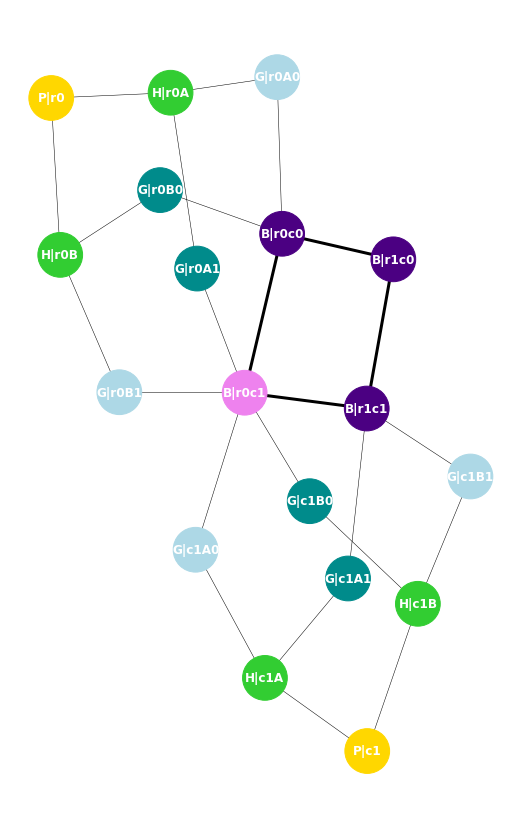

In [44]:
display_kamada_kawai(expeG)

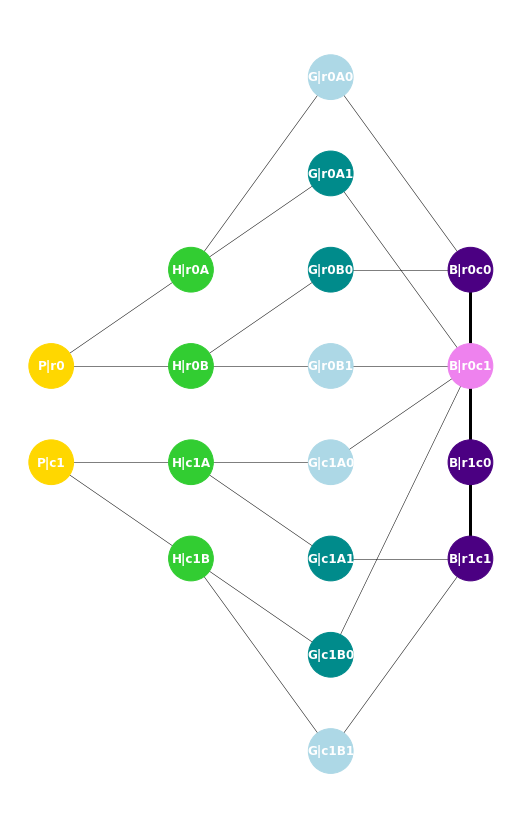

In [45]:
display_layers(expeG)

G:r0B1 which is filler is not consistent with B|r0c0 being back

the parent hypothesis H|r0B is broken, and all the groups in the hypothesis

In [46]:
# lookup group which group state does not match at least a cell state of the group
# find path between groups of state filler -> state to the cells of state black
filler_groups = [name for name, attr in expeG.nodes(data=True) 
                 if attr['role'] == Roles.GROUP and attr['state'] == BoardMark.FILLER.value]
black_cells = [name for name, attr in expeG.nodes(data=True) 
               if attr['role'] == Roles.BOARD and attr['state'] == BoardMark.BLACK.value ]

In [47]:
filler_groups

['G|r0A0', 'G|r0B1', 'G|c1A0', 'G|c1B1']

In [48]:
black_cells

['B|r0c0', 'B|r1c0', 'B|r1c1']

In [49]:
filler_groups = [name for name, attr in expeG.nodes(data=True) 
                 if attr['role'] == Roles.GROUP and attr['state'] == BoardMark.FILLER.value]
black_cells = [name for name, attr in expeG.nodes(data=True) 
               if attr['role'] == Roles.BOARD and attr['state'] == BoardMark.BLACK.value ]    
inconsistent_groups = []
for source in filler_groups:
    paths = list(nx.all_simple_paths(expeG, source, black_cells, cutoff=1))
    print(paths)
    for path in paths:
        print(expeG.nodes[path[0]])
        print(expeG.nodes[path[1]])    
        inconsistent_groups.append(path[0])  # source is a group
    
inconsistent_groups

[['G|r0A0', 'B|r0c0']]
{'role': <Roles.GROUP: 2>, 'row': 1, 'state': 0, 'layer': 2, 'color': 'lightblue'}
{'role': <Roles.BOARD: 3>, 'row': 0, 'col': 0, 'state': 1, 'layer': 3, 'color': 'indigo'}
[]
[]
[['G|c1B1', 'B|r1c1']]
{'role': <Roles.GROUP: 2>, 'col': 1, 'state': 0, 'layer': 2, 'color': 'lightblue'}
{'role': <Roles.BOARD: 3>, 'row': 1, 'col': 1, 'state': 1, 'layer': 3, 'color': 'indigo'}


['G|r0A0', 'G|c1B1']

In [50]:
def lookup_inconsistent_groups(a_graph):
    group_states = [BoardMark.FILLER, BoardMark.BLACK]
    cell_states = [BoardMark.BLACK, BoardMark.FILLER]
    inconsistent_groups = []
    for state_group, state_cell in zip(group_states,cell_states):
        filler_groups = [name for name, attr in a_graph.nodes(data=True) 
                         if attr['role'] == Roles.GROUP and attr['state'] == state_group.value]
        black_cells = [name for name, attr in a_graph.nodes(data=True) 
                       if attr['role'] == Roles.BOARD and attr['state'] == state_cell.value ]    
        for source in filler_groups:
            paths = list(nx.all_simple_paths(a_graph, source, black_cells, cutoff=1))
            #print(paths)
            for path in paths:
                #print(a_graph.nodes[path[0]])
                #print(a_graph.nodes[path[1]])    
                inconsistent_groups.append(path[0])  # source is a group
    
    return inconsistent_groups

In [51]:
inconsistent_groups = lookup_inconsistent_groups(expeG)  
inconsistent_groups

['G|r0A0', 'G|c1B1']

In [55]:
# lookup hypothesis which contains this group 
inconsistent_hyps = [] 
for source in inconsistent_groups:
    paths = list(nx.all_simple_paths(expeG, source, hyps, cutoff=1))
    print(paths)
    for path in paths:
        inconsistent_hyps.append(path[1]) # target is an hypothesis

inconsistent_hyps

[['G|r0A0', 'H|r0A']]
[['G|c1B1', 'H|c1B']]


['H|r0A', 'H|c1B']

In [53]:
def lookup_inconsistent_hypothesis(a_graph, some_inconsistent_groups):
    hyps = [name for name, role in a_graph.nodes(data='role') if role == Roles.HYPOTHESIS]
    inconsistent_hyps = [] 
    for source in some_inconsistent_groups:
        paths = list(nx.all_simple_paths(a_graph, source, hyps, cutoff=1))
        #print(paths)
        for path in paths:
            inconsistent_hyps.append(path[1]) # target is an hypothesis

    return inconsistent_hyps

In [56]:
inconsistent_hyps = lookup_inconsistent_hypothesis(expeG, inconsistent_groups)
inconsistent_hyps

['H|r0A', 'H|c1B']

In [57]:
# can remove those groups and hypothesis
# must remove all groups of each hypothesis
def remove_inconsistent_hypothesis(a_graph, some_inconsistent_hypothesis):
    groups = [name for name, role in a_graph.nodes(data='role') if role == Roles.GROUP]
    for hyp in some_inconsistent_hypothesis:
        group_paths = list(nx.all_simple_paths(a_graph, hyp, groups, cutoff=1))
        print(group_paths)
        # remove each group of the hypothesis
        for group_path in group_paths:
            group_name = group_path[1]
            a_graph.remove_node(group_name)

    a_graph.remove_nodes_from(inconsistent_hyps)   

In [58]:
remove_inconsistent_hypothesis(expeG, inconsistent_hyps)

[['H|r0A', 'G|r0A1'], ['H|r0A', 'G|r0A0']]
[['H|c1B', 'G|c1B0'], ['H|c1B', 'G|c1B1']]


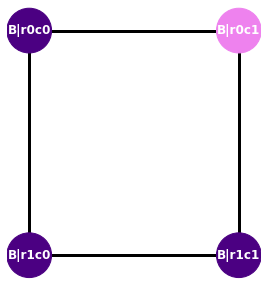

In [59]:
display_board(expeG)

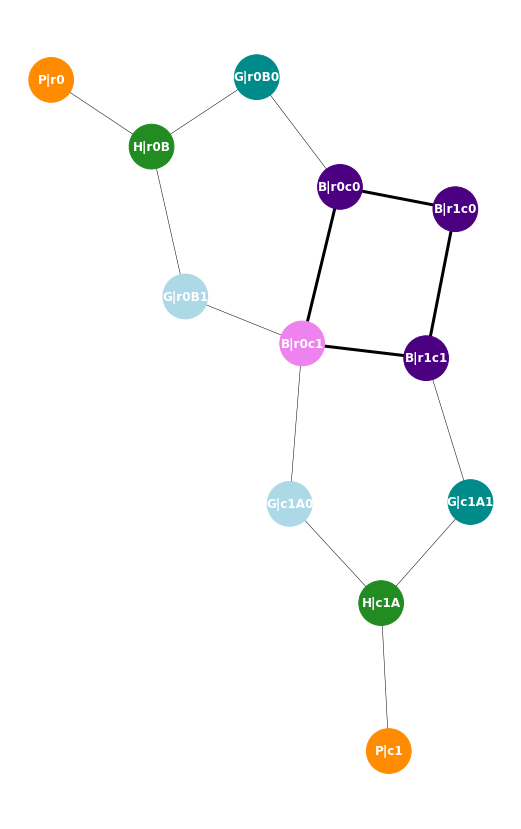

In [61]:
display_kamada_kawai(expeG)

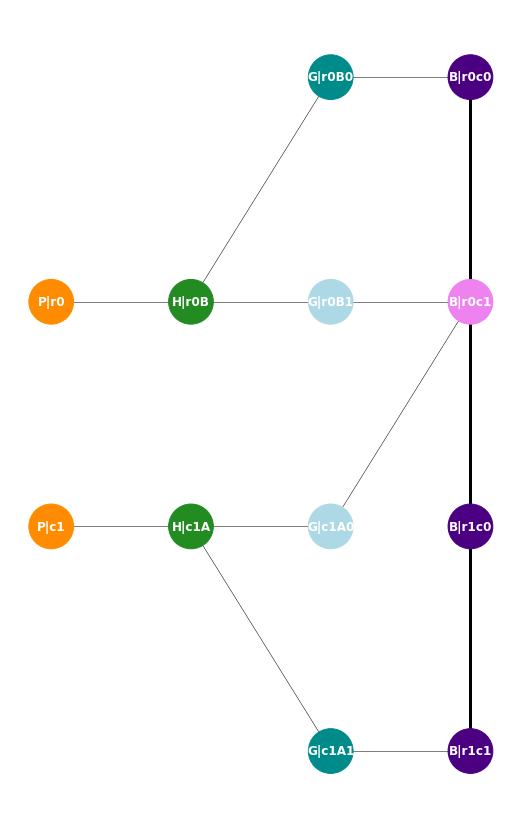

In [62]:
display_layers(expeG)

In [63]:
single_hypothesis = lookup_single_hypothesis(expeG)
single_hypothesis

['H|r0B', 'H|c1A']

In [64]:
apply_single_hypothesis(expeG, single_hypothesis)

group_name:G|r0B1 -> cell_name:B|r0c1
group_name:G|r0B0 -> cell_name:B|r0c0
group_name:G|c1A1 -> cell_name:B|r1c1
group_name:G|c1A0 -> cell_name:B|r0c1


In [65]:
remove_single_hypothesis(expeG, single_hypothesis)

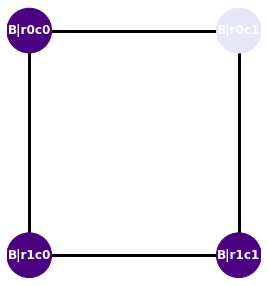

In [66]:
display_board(expeG)

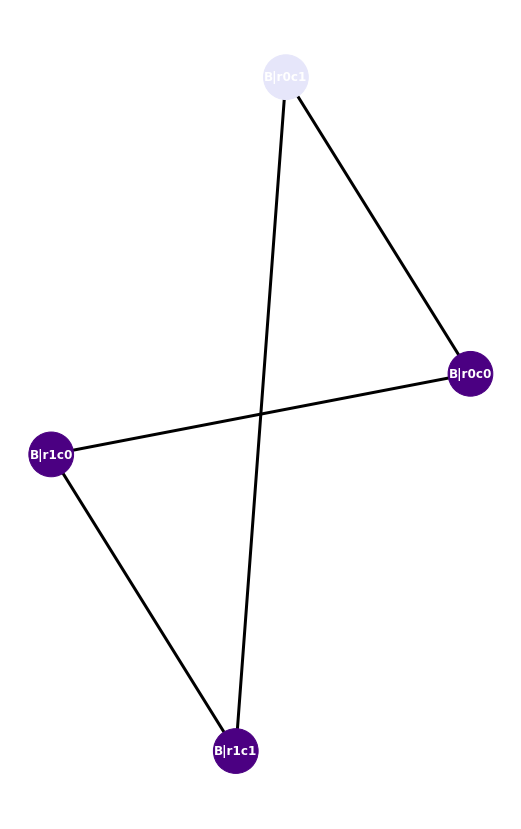

In [67]:
display_kamada_kawai(expeG)

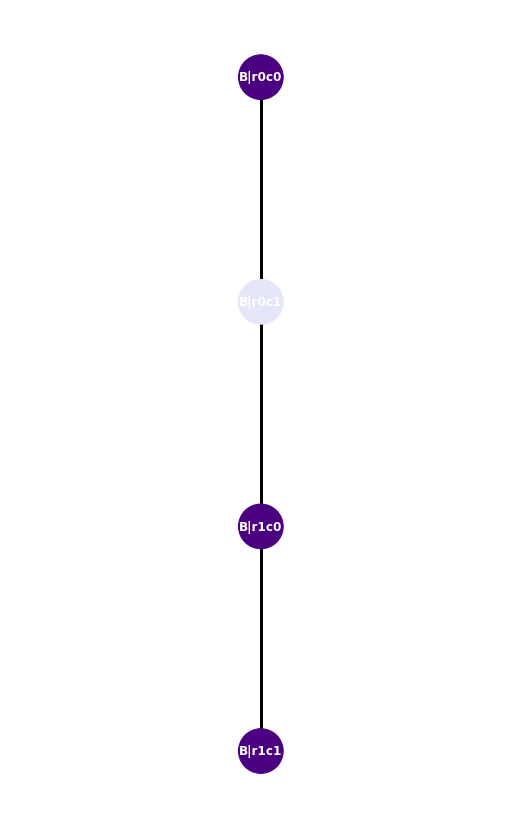

In [68]:
display_layers(expeG)

# TODO test d'arret 

# TODO Wrap up 

what we learned

networkx documentation expecialuyt for drawings

graph mindset (look for path and operation on collections)

implemen 10h

desing 4h (where to start witth)

same as first iilmpression with classes - cleaner and with visual reprewentation